In [3]:
import numpy as np 
import pandas as pd 

DEBUG = True
DATA_SIZE = 20_000
SEED = 20723

# FILE LOCATIONS
DATA_LOCATION = 'New_Delhi_reviews.csv'
CLEAN_DATA_LOCATION = 'clean.df'
SAVE_MODEL_LOCATION = 'best_model.h5'

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
df = pd.read_csv(DATA_LOCATION)
if DEBUG:
    df_example = df.iloc[[4_001,4_002],:]
    print(df_example)
    print(df_example.iloc[0]['review_full'])
    print(np.unique(df['rating_review']))

,rating_review,review_full
0,5,"Totally in love with the Auro of the place, re..."
1,5,I went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea..."


## Clean

In [4]:
import sys  
!{sys.executable} -m pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.8 MB/s eta 0:00:00


In [6]:
# imports for text cleaning
#%pip install contractions
import contractions
import re
import nltk
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk.tokenize import wordpunct_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
# helper function to convert the pos tag format into something compatible with the lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def clean_doc(doc, stop_words, lemmatizer):
    # expand contractions
    try:
        doc = contractions.fix(doc)
    except:
        if DEBUG:
            print(doc)
        return
    # remove every char that is not alphanumeric, keep spaces
    doc = re.sub(r'\W+', ' ', doc) 
    
    # get lowercase tokens that are not very common words
    tokens = wordpunct_tokenize(doc) 
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words] 
    
    # lemmatize tokens based on pos tags
    pos = pos_tag(tokens)
    clean_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos]
    
    # put tokens back into string format for tfidf vectorizer
    #clean_doc = " ".join(clean_tokens)

    return clean_tokens

def clean_data(data):
    en_stop_words = stopwords.words("english")
    wn_lemmatizer = WordNetLemmatizer()
    clean_data = pd.DataFrame()
    clean_data['text'] = data['review_full'].apply(lambda x: clean_doc(x, en_stop_words, wn_lemmatizer))
    clean_data['label'] = data['rating_review']
    clean_data = clean_data.dropna()
    return clean_data

In [44]:
#df_head = df.head(20_000)
#df_head = df.groupby('rating_review', group_keys=False).apply(lambda x: x.head(4_000))
df_head = df.groupby('rating_review', group_keys=False).apply(lambda x: x.sample(n=int(np.ceil(DATA_SIZE / 5)), random_state=SEED))

     rating_review                                        review_full
115              1  The service was OK and the food seemed good. E...
174              1  Worst experience we had in a bar so far. Cockt...
223              1  Good Food My Chinese Group Like This Restauran...
547              1  I went to Kylin to celebrate my Mom & Dad's an...
608              1  The food at Coast Cafe last night was horrible...


In [4]:
clean_df = clean_data(df_head)
if DEBUG:
    clean_df_example = clean_data(df_example)
    print(clean_df_example)
    print(clean_df_example.iloc[0]['text'])
    print((clean_df['label'].value_counts()) / len(clean_df) * 100)

NameError: name 'clean_data' is not defined

In [46]:
clean_df.to_pickle(CLEAN_DATA_LOCATION)


## Split

In [5]:
clean_df = pd.read_pickle(CLEAN_DATA_LOCATION)
if DEBUG:
    print(clean_df.head())

                                                  text  label
115  [service, ok, food, seem, good, except, wife, ...      1
174  [bad, experience, bar, far, cocktails, almost,...      1
223  [good, food, chinese, group, like, restaurant,...      1
547  [go, kylin, celebrate, mom, dad, anniversary, ...      1
608  [food, coast, cafe, last, night, horrible, see...      1


In [6]:
train_df = clean_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=SEED))
test_df = clean_df.drop(train_df.index, axis=0)
if DEBUG:
    print(train_df.head(5))
    print((train_df['label'].value_counts()) / len(train_df) * 100)

                                                     text  label
15184   [endorse, frequent, artusi, ever, since, incep...      1
132793  [last, option, sit, parked, car, couple, want,...      1
120322  [lunch, oh, calcutta, 5th, may, staff, prefer,...      1
132338  [birthday, decide, take, family, great, kabab,...      1
89710   [decide, visit, outlet, christmas, dinner, say...      1
1    20.001111
2    20.001111
3    20.001111
4    20.001111
5    19.995555
Name: label, dtype: float64


/tmp/ipykernel_33/1503272378.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rated["word_count"] = data_rated["text"].apply(word_count)


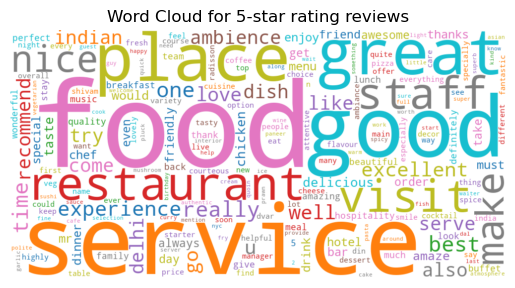

/tmp/ipykernel_33/1503272378.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rated["word_count"] = data_rated["text"].apply(word_count)


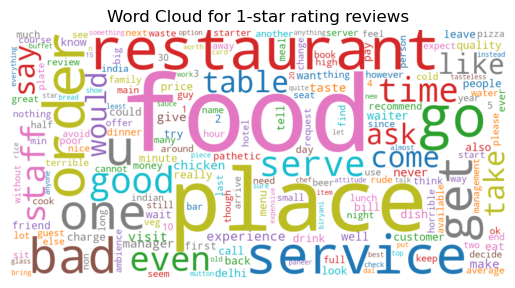

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def word_count(words):
    counts = dict()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

def all_word_counts(data, rating):
    data_rated = data[data["label"]==rating]
    data_rated["word_count"] = data_rated["text"].apply(word_count)
    all_counts = {}
    for counts in data_rated["word_count"]:
        for word, count in counts.items():
            if word in all_counts:
                all_counts[word] += count
            else:
                all_counts[word] = count
    return all_counts

def plot_wordcloud(word_freq, rating):           
    wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap='tab10', random_state=seed).generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Word Cloud for {rating}-star rating reviews')
    plt.axis("off")
    plt.savefig(f'plot{rating}.png')
    plt.show()
    

all_counts = all_word_counts(train_df, 5)
plot_wordcloud(all_counts, 5)
all_counts = all_word_counts(train_df, 1)
plot_wordcloud(all_counts, 1)

## Vectorize

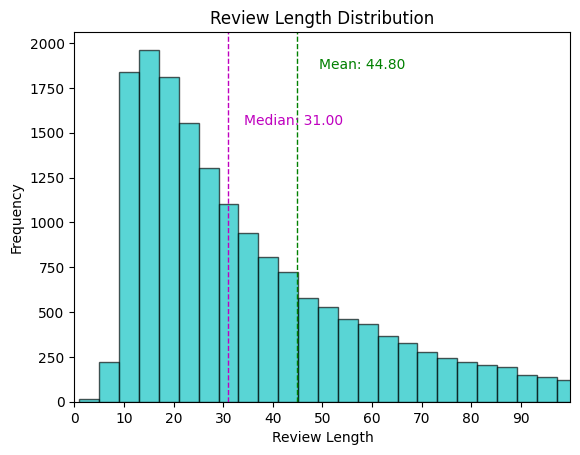

In [23]:
import matplotlib.pyplot as plt

def get_len_dist(data):
    data["len"] = data["text"].apply(lambda x: len(x))
    return data["len"].to_numpy(dtype=int)

def plot_len_dist(lengths):
    plt.hist(lengths, bins=200, color='c', edgecolor='k', alpha=0.65)
    plt.xlabel('Review Length')
    plt.ylabel('Frequency')
    plt.title('Review Length Distribution')
    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 100, 10))
    plt.axvline(np.median(lengths), color='m', linestyle='dashed', linewidth=1)
    plt.axvline(lengths.mean(), color='g', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.median(lengths)*1.1, max_ylim*0.75, 'Median: {:.2f}'.format(np.median(lengths)), color='m')
    plt.text(lengths.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(lengths.mean()), color='g')
    plt.show()
    
lens = get_len_dist(train_df)
plot_len_dist(lens)


In [1]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

def vectorize(data, tokenizer=None, max_len=40):
    #max_words = 5000
    # train a new tokenizer
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(data)
    sequences = tokenizer.texts_to_sequences(data)
    padded = pad_sequences(sequences, maxlen=max_len)
    return padded, tokenizer

In [7]:
X_train, tokenizer = vectorize(train_df['text'])
y_train = train_df['label'].apply(lambda x: x-1)

VOCAB_SIZE = len(tokenizer.word_index) + 1

if DEBUG:
    print(X_train)
    print(y_train)
    X_example, _ = vectorize(clean_df_example['text'], tokenizer)
    print("Example sequence for report:", X_example[0])
    print(f"Vocabulary size: {VOCAB_SIZE}")

X_test, _ = vectorize(test_df['text'], tokenizer)
y_test = test_df['label']

[[1646 2334 2445 ... 2409    3 6242]
 [   0    0    0 ...    3  178   97]
 [2296 3191  244 ...   11 2633  398]
 ...
 [   0    0    0 ...  152  543 3992]
 [   0    0    0 ... 2743    1  100]
 [   0    0    0 ...    3  334 5883]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


## Tuning

In [30]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [52]:
def build_model(units, learn_rate, dropout, classes=5, max_len=40):
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=units, input_length=max_len, mask_zero=True))
    model.add(Bidirectional(LSTM(units, dropout=dropout)))
    model.add(Dense(classes, activation='softmax'))
    
    rmsprop = RMSprop(learning_rate=learn_rate)
    
    model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #if DEBUG:
    #    print(model.summary())
    
    return model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

from scikeras.wrappers import KerasClassifier
EPOCHS = 10
PATIENCE = 3
ITER = 10
CV = 5

model = KerasClassifier(model=build_model, random_state=SEED, epochs=EPOCHS, callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)])

param_grid = {
    'model__units': [64, 128, 256],
    'model__dropout': [0.1, 0.2, 0.3, 0.5],
    'model__learn_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'batch_size': [32, 64, 128]
}
rand = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=ITER, n_jobs=-1, cv=CV, random_state=SEED)
rand_result = rand.fit(X_train, y_train)

## Final model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 100)           2474700   
                                                                 
 bidirectional_4 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 2,636,505
Trainable params: 2,636,505
Non-trainable params: 0
_________________________________________________________________
None


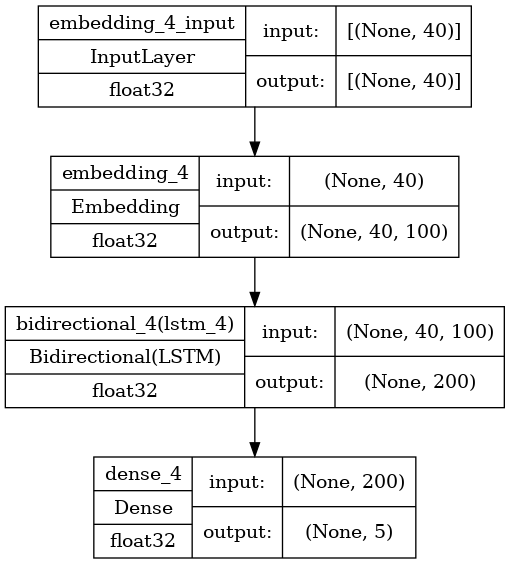

In [61]:
# model = build_model(best parameters) 
# train on all training data (?) or just 0.9 to get a plot with validation loss as well?
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

Epoch 1/10
506/507 [============================>.] - ETA: 0s - loss: 0.8892 - accuracy: 0.6187
Epoch 1: val_accuracy improved from -inf to 0.90611, saving model to /kaggle/working/best_model.h5
507/507 [==============================] - 37s 65ms/step - loss: 0.8890 - accuracy: 0.6188 - val_loss: 0.3009 - val_accuracy: 0.9061
Epoch 2/10
506/507 [============================>.] - ETA: 0s - loss: 0.7516 - accuracy: 0.6810
Epoch 2: val_accuracy did not improve from 0.90611
507/507 [==============================] - 32s 62ms/step - loss: 0.7514 - accuracy: 0.6810 - val_loss: 0.4640 - val_accuracy: 0.7839
Epoch 3/10
506/507 [============================>.] - ETA: 0s - loss: 0.7076 - accuracy: 0.7016
Epoch 3: val_accuracy did not improve from 0.90611
507/507 [==============================] - 32s 62ms/step - loss: 0.7079 - accuracy: 0.7014 - val_loss: 0.6909 - val_accuracy: 0.7300
Epoch 4/10
506/507 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.7215
Epoch 4: val_acc

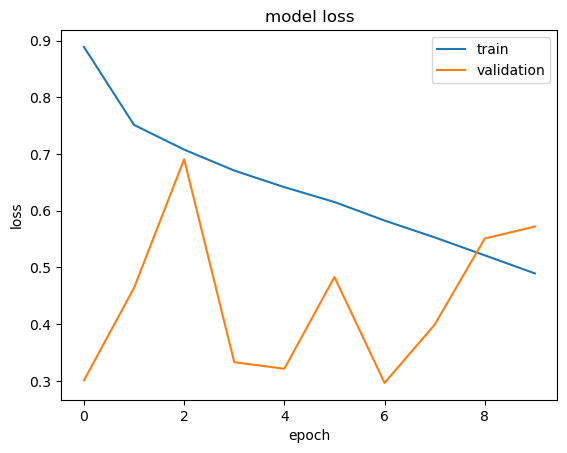

In [62]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

history = train_model(model, X_train, y_train)
plot_loss(history)

## Evaluation

In [68]:
from sklearn.metrics import accuracy_score
preds = model.predict(X_test)
pred_classes = [np.argmax(line)+1 for line in preds]
print(accuracy_score(y_test, pred_classes))

63/63 [==============================] - 1s 14ms/step
0.647823911955978
